In [1]:
from pandas import read_csv

data = read_csv('stats.csv')
data.drop("index", axis=1, inplace=True)
data.drop("id", axis=1 , inplace=True)
data = data.dropna()
data.head()

,label,ecc_mean,ecc_min,ecc_max,ecc_sd,ecc_skew,ecc_10pc,ecc_1q,ecc_median,ecc_3q,...,solidity_mean,solidity_min,solidity_max,solidity_sd,solidity_skew,solidity_10pc,solidity_1q,solidity_median,solidity_3q,solidity_90pc
0,0,0.801306,0.593695,0.966819,0.125172,-0.137639,0.658744,0.686168,0.819708,0.912999,...,0.795114,0.373303,0.958955,0.170381,-1.147909,0.662281,0.717273,0.816754,0.937572,0.948276
1,1,0.837111,0.587075,0.968586,0.111798,-0.824572,0.706076,0.794921,0.864257,0.904624,...,0.796183,0.469914,0.962025,0.148221,-0.692320,0.631471,0.721875,0.817094,0.927075,0.961551
2,0,0.783310,0.382105,0.988181,0.138827,-1.069424,0.682008,0.744029,0.768124,0.846584,...,0.828778,0.567123,0.963816,0.114403,-1.003540,0.665998,0.783846,0.848188,0.909219,0.946858
3,0,0.824015,0.617894,0.981266,0.111468,-0.466777,0.668586,0.729426,0.865206,0.900536,...,0.809020,0.644663,0.959538,0.092679,-0.141705,0.702436,0.719346,0.834454,0.866532,0.921804
4,0,0.660254,0.330568,0.954411,0.159412,-0.067673,0.456213,0.569537,0.635749,0.771979,...,0.872813,0.574759,0.980170,0.098507,-1.361063,0.734985,0.843023,0.907530,0.943089,0.965369


In [32]:
# Size of test group
###################################
size = 0.1
###################################

from sklearn.model_selection import train_test_split

X = data.loc[:, data.columns != "label"]
y = data["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=42)

for x in (X_train, X_test, y_train, y_test):
    print(x.shape)

(197991, 30)
(22000, 30)
(197991,)
(22000,)


In [33]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rf = RandomForestClassifier(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 20, num = 4)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth = [5,15,50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = { 
    'n_estimators': [50,200,666,2000,2500],
    'max_features': ['auto', 'sqrt', 'log2'],
    "min_samples_split": [2, 3, 10, 50,100],
    'max_depth' : [4,8,12,20,40],
    #'bootstrap': [True,False],
    'criterion' :['gini', 'entropy']
}

pprint(random_grid)

{'criterion': ['gini', 'entropy'],
 'max_depth': [4, 8, 12, 20, 40],
 'max_features': ['auto', 'sqrt', 'log2'],
 'min_samples_split': [2, 3, 10, 50, 100],
 'n_estimators': [50, 200, 666, 2000, 2500]}


In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/home/andrea/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 75.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 464.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 1009.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [40]:
rf_random.best_params_ 

{'n_estimators': 2000,
 'min_samples_split': 10,
 'max_features': 'auto',
 'max_depth': 40,
 'criterion': 'entropy'}

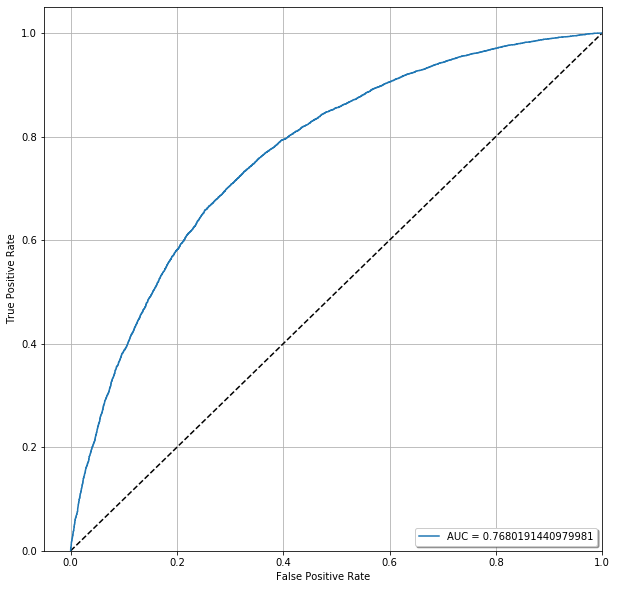

In [37]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# overall accuracy
acc = rf_random.score(X_test,y_test)

# get roc/auc info
Y_score = rf_random.predict_proba(X_test)[:,1]
fpr = dict()
tpr = dict()
fpr, tpr, _ = roc_curve(y_test, Y_score)

roc_auc = dict()
roc_auc = auc(fpr, tpr)

# make the plot
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
plt.legend(loc="lower right", shadow=True, fancybox =True) 
plt.show()


In [38]:
y_pred = rf_random.predict(X_test)

In [39]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77     14118
           1       0.59      0.66      0.62      7882

    accuracy                           0.71     22000
   macro avg       0.69      0.70      0.69     22000
weighted avg       0.72      0.71      0.71     22000

